# Download and prepare data
This notebooks shows the original steps taken to download and prepare the data. Running this notebook again won't be necessary, as we provide the already prepared data here: TODO


Download data from TissueMap instance on pelkmanslab server using Scotts mcu package.

Install needed external packages:
```
# install MCU
pip install git+https://github.com/scottberry/mcu.git
# install TissueMaps dependencies
conda install opencv # or pip install opencv-contrib-python
pip install prettytable pyyaml scikit-image
# install TissueMaps
cd LIBS_DIR
git clone https://github.com/TissueMAPS/TissueMAPS.git
pip install -e ./TissueMaps/tmclient --no-deps
```

Requires well_names.csv and cell_cycle_classification.csv in DATA_DIR/metadata_raw

In [1]:
#from campa_ana.tm_data import get_tm_client, download_channels_metadata, download_wells_metadata
from campa_ana.constants import SOURCE_DIR
from campa.constants import get_data_config
from campa.data import MPPData
import os, shutil
import pandas as pd
import glob
from campa.utils import load_config

Reading config from [PosixPath('/Users/hannah.spitzer/.config/campa/campa.ini'), PosixPath('/Users/hannah.spitzer/projects/pelkmans/software_new/campa_ana/workflow/campa.ini'), PosixPath('/Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini')]


## NascentRNA dataset

In [4]:
params = load_config(os.path.join(SOURCE_DIR, "params/download_params.py"))
DATA_CONFIG = get_data_config("NascentRNA")
DATA_DIR = DATA_CONFIG.DATA_DIR

data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']] + \
            [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, '184A1_meayamycin', well) for well in ['I12', 'I20']] + \
            [os.path.join(DATA_DIR, '184A1_EU10', well) for well in ['H07', 'I08', 'J07']] + \
            [os.path.join(DATA_DIR, '184A1_SBF2', well) for well in ['K18', 'L19', 'M18']] + \
            [os.path.join(DATA_DIR, '184A1_scrambled', well) for well in ['K19', 'L18', 'M19']]

### Downlad channels and wells metadata

In [3]:
tm_client = get_tm_client(params.tm_credentials)
# channels information
download_channels_metadata(tm_client, os.path.join(DATA_DIR, 'channels_metadata.csv'))
# wells information
download_wells_metadata(tm_client, os.path.join(DATA_DIR, 'wells_metadata.csv'), data_dir=DATA_DIR)

### Download mpp data
Downloads mpp data to individual per-well folders with individual metadata.csv files

`scripts/download_mpp.sh`

In [6]:
# move mapobject_ids.npy to obj_ids.npy
for data_dir in data_dirs:
    try:
        shutil.move(os.path.join(data_dir, 'mapobject_ids.npy'), os.path.join(data_dir, "obj_ids.npy"))
    except FileNotFoundError as e:
        print(f"{data_dir} did not find mapobject_ids.npy")

/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I09 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I11 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J10 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J12 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/I14 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/J16 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I13 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I17 did not find mapobject_ids.npy
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A

### Merge metadata.csv with wells metadata and cell cycle classification

In [3]:
cell_cycle = pd.read_csv(os.path.join(DATA_DIR, 'metadata_raw/selected_cells_no_extreme_dapi_cell_cycle_classification.csv'))
wells = pd.read_csv(os.path.join(DATA_DIR, "wells_metadata.csv"), index_col=0)

def merge_metadata(metadata_file):
    metadata = pd.read_csv(metadata_file, index_col=0)
    # ensure that actually updates cell_cycle values 
    if 'cell_cycle' in metadata.columns:
        metadata = metadata.drop(columns=['cell_cycle'])
    df = metadata.merge(cell_cycle, left_on='mapobject_id_cell', right_on='mapobject_id', how='left', suffixes=('','_cc'))
    # remove duplicate columns
    df = df.drop(columns=[c for c in df.columns if c.endswith('_cc')])
    df = df.merge(wells, left_on='well_name', right_on='well_name', how='left', suffixes=('', '_well'))
    df = df.drop(columns=[c for c in df.columns if c.endswith('_well')])

    df.to_csv(metadata_file)


In [4]:
for data_dir in data_dirs:
    try:
        merge_metadata(os.path.join(data_dir, 'metadata.csv'))
        print(f"{data_dir} updated metadata")
    except FileNotFoundError as e:
        print(f"{data_dir} does not exist")


/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I09 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I11 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J10 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J12 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/I14 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/J16 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I13 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I17 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J14 updated metadata
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J

### Add cell crowding feature to metadata
values are in _CellAggregate folder

In [5]:
# read all cellcrowding features
cell_crowding_path = os.path.join(DATA_DIR, 'metadata_raw/NascentRNA_CellAggregate/201908-NascentRNA-4i/POPCON/201908-NascentRNA-4i_plate01_*_Cells_popcon.csv')
cell_crowding = []
for f in glob.glob(cell_crowding_path):
    cell_crowding.append(pd.read_csv(f))
cell_crowding = pd.concat(cell_crowding, axis='index')

columns_to_add = ['LocalDensity_Nuclei_800']

def add_cell_crowding(metadata_file):
    metadata = pd.read_csv(metadata_file, index_col=0)
    # remove previous values from metadata
    metadata = metadata.drop(columns=[c for c in metadata.columns if c in columns_to_add])
    metadata = metadata.merge(cell_crowding[['mapobject_id']+columns_to_add], how='left', left_on='mapobject_id_cell', right_on='mapobject_id', suffixes=('', '_y'))
    # remove mapobject_id added with cell_crowding
    metadata = metadata.drop(columns=['mapobject_id_y'])
    # save metadata
    metadata.to_csv(metadata_file)


In [6]:
for data_dir in data_dirs:
    try:
        add_cell_crowding(os.path.join(data_dir, 'metadata.csv'))
        print(f"{data_dir} added cell crowding")
    except FileNotFoundError as e:
        print(f"{data_dir} does not exist")

/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I09 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/I11 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J10 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_unperturbed/J12 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/I14 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_DMSO/J16 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I13 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/I17 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/NascentRNA_new/184A1_AZD4573/J14 added cell crowding
/Users/hannah.spitzer/projects/pelkmans/local_data/Nas

In [39]:
#from campa.data import MPPData
#import importlib
#import campa.data
#importlib.reload(campa)
#import campa
#importlib.reload(campa.data._data)

#import campa.utils
#campa.utils.init_logging()

<module 'miann.data._data' from '/Users/hannah.spitzer/projects/pelkmans/software_new/miann/miann/data/_data.py'>

### Add TR value to metadata 
Compute TR as mean 00_EU value per cell. For replicate wells, compute per-well median TR and overall median TR to normalise per-well TR values:

```
TR_factor = median_TR / per_well_median_TR
TR_norm = TR * TR_factor
```

In [11]:
OBJ_ID = DATA_CONFIG.OBJ_ID
def calculate_TR(data_dirs, normalise=False):
    mpp_data = MPPData.concat([MPPData.from_data_dir(d) for d in data_dirs])
    TR = mpp_data.center_mpp[:, list(mpp_data.channels.name).index('00_EU')]

    # calculate per-well TR mean (using overall obj_id TRs -- disregarding cell size!)
    df = pd.DataFrame({'TR': TR, OBJ_ID: mpp_data.obj_ids})
    df_mean_obj = df.groupby(OBJ_ID).mean()
    df_mean_obj = df_mean_obj.merge(mpp_data.metadata[[OBJ_ID, 'well_name']], left_index=True, right_on=OBJ_ID, how='left')
    if normalise:
        # calculate normed TR
        df_median_well = df_mean_obj.groupby('well_name')['TR'].median()
        factors = df_mean_obj['TR'].median() / df_median_well
        # project per-well mean back to obj_id
        df_mean_obj = df_mean_obj.merge(factors, left_on='well_name', right_index=True, how='left', suffixes=('', '_factor'))
        df_mean_obj['TR_norm'] = df_mean_obj['TR'] * df_mean_obj['TR_factor']
    return df_mean_obj

def update_metadata_with_TR(data_dirs, df_mean_obj, normalise=False, normalise_suffix=''):
    # write TR, TR_factor, and TR_norm to metadata.csv
    cols = [OBJ_ID, 'TR']
    if normalise:
        cols.extend(['TR_factor'+normalise_suffix, 'TR_norm'+normalise_suffix])
    for d in data_dirs:
        metadata = pd.read_csv(os.path.join(d, 'metadata.csv'), index_col=0)
        metadata = metadata.merge(df_mean_obj[cols], on=OBJ_ID, how='left', suffixes=('_OLD', ''))
        # remove previous TR values
        metadata = metadata.drop(columns=[c for c in metadata.columns if c.endswith('_OLD')])
        metadata.to_csv(os.path.join(d, 'metadata.csv'))


#### EU10 wells
TR_norm can be used in models trained on only EU10 wells

well_name
H07    0.978401
I08    1.029819
J07    0.992759
Name: TR_factor, dtype: float64

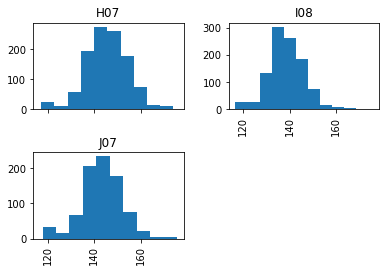

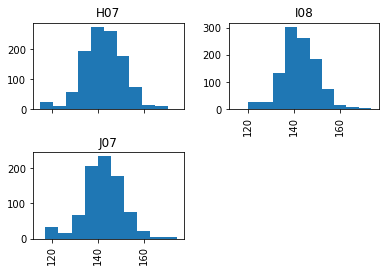

In [10]:
data_dirs = [os.path.join(DATA_DIR, '184A1_EU10', well) for well in ['H07', 'I08', 'J07']]

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

#### Unperturbed wells
TR_norm can be used in models trained on only unperturbed wells

well_name
I09    0.974852
I11    0.996274
J10    0.996179
J12    1.030196
Name: TR_factor, dtype: float64

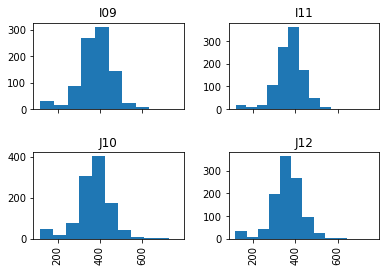

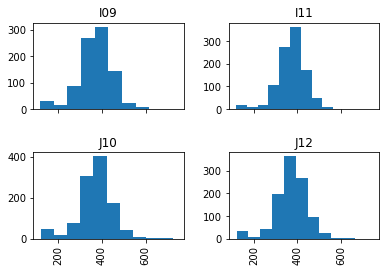

In [12]:
data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']]

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

#### SBF2 wells
TR_norm can be used in models trained on only SBF2 wells

TODO: these values differ from before. Possible reason: before used nuclei only, now use entire cells for TR calculation. Need to find a way to subset to nuclei for SBF2 wells

well_name
K18    1.236372
K19    0.960502
L18    0.969554
L19    1.147594
M18    1.157559
M19    0.917991
Name: TR_factor, dtype: float64

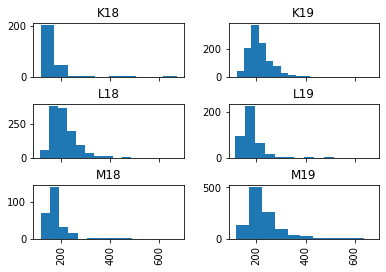

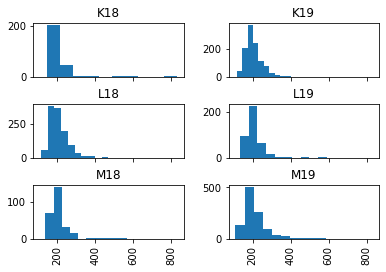

In [13]:
data_dirs =  [os.path.join(DATA_DIR, 'HeLa_SBF2', well) for well in ['K18', 'L19', 'M18']] + \
              [os.path.join(DATA_DIR, 'HeLa_scrambled', well) for well in ['K19', 'L18', 'M19']]

df = calculate_TR(data_dirs, normalise=True)
update_metadata_with_TR(data_dirs, df, normalise=True)

# show results
display(df.groupby('well_name')['TR_factor'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm'].hist(by=df['well_name'], sharex=True)

#### Perturbation wells
only write TR

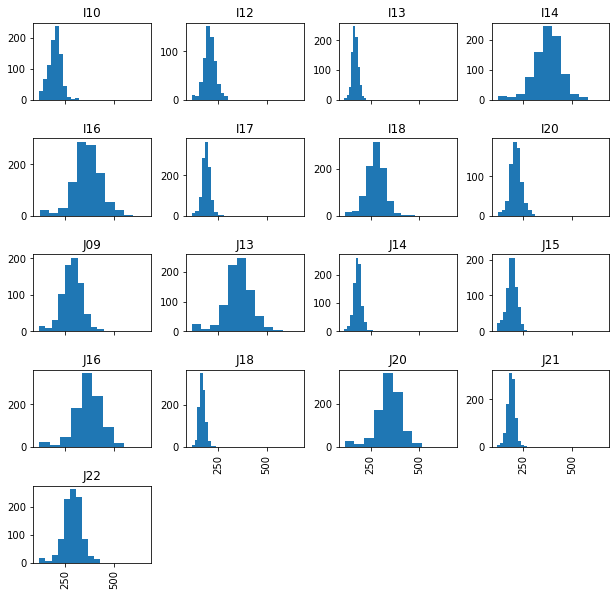

In [14]:
data_dirs = [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, '184A1_meayamycin', well) for well in ['I12', 'I20']]

df = calculate_TR(data_dirs, normalise=False)
update_metadata_with_TR(data_dirs, df, normalise=False)

# show results
_ = df['TR'].hist(by=df['well_name'], sharex=True, figsize=(10,10))

#### DMSO + Unperturbed wells together (TR_norm_DMSO-unperturbed)

well_name
I09    0.974852
I11    0.996274
I14    0.984474
J10    0.996179
J12    1.030196
J16    1.010853
Name: TR_factor_DMSO-unperturbed, dtype: float64

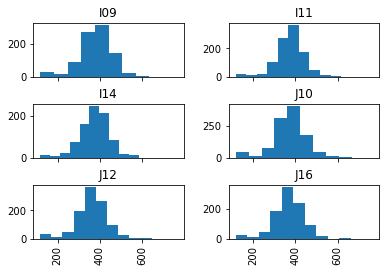

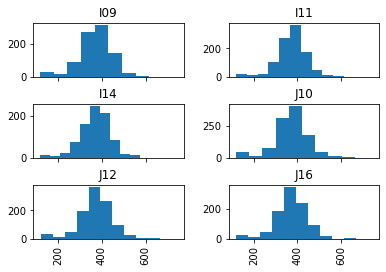

In [14]:
data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']] + \
            [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']]

df = calculate_TR(data_dirs, normalise=True)
df = df.rename(columns={'TR_norm': 'TR_norm_DMSO-unperturbed', 'TR_factor': 'TR_factor_DMSO-unperturbed'})
update_metadata_with_TR(data_dirs, df, normalise=True, normalise_suffix='_DMSO-unperturbed')

# show results
display(df.groupby('well_name')['TR_factor_DMSO-unperturbed'].first())
_ = df['TR'].hist(by=df['well_name'], sharex=True)
_ = df['TR_norm_DMSO-unperturbed'].hist(by=df['well_name'], sharex=True)

### Add mean_background to channels_metadata
Read from secondary_only_relative_normalisation, containing background values obtained from empty wells

In [16]:
channels_metadata = pd.read_csv(os.path.join(DATA_DIR, 'channels_metadata.csv'), index_col=0)
bkgrd = pd.read_csv(os.path.join(DATA_DIR, 'metadata_raw', 'secondary_only_relative_normalisation.csv'))

# use non-cell background measurements from HeLa wells as background values per channel
bkgrd = bkgrd.loc[bkgrd['measurement_type'] == "non-cell"].loc[bkgrd['cell_line']== "HeLa"]
bkgrd = bkgrd[['channel','mean_background']].reset_index(drop=True)

# merge bkgrd to channels_metadata
channels_metadata = channels_metadata.merge(bkgrd, how='left', left_on='name', right_on='channel', suffixes=('_OLD', '')).drop(columns=['channel'])
channels_metadata = channels_metadata.drop(columns=[c for c in channels_metadata.columns if c.endswith('_OLD')])
channels_metadata.to_csv(os.path.join(DATA_DIR, 'channels_metadata.csv'))

channels_metadata

,id,name,max_intensity,min_intensity,mean_background
0,3,00_BG488,351,96,109.266166
1,2,00_BG568,349,94,106.990196
2,1,00_DAPI,350,95,107.700000
3,7,00_EU,748,97,NaN
4,8,01_CDK9_pT186,349,94,107.110922
...,...,...,...,...,...
78,79,22_DDX6,853,95,106.578549
79,80,22_DDX6_ILASTIK,63242,0,NaN
80,83,22_H2B,351,96,NaN
81,82,22_NPM1,350,95,107.906872


# Download Ilastik channels
Using `download_params_ilastik.py` we can download Ilastik channels with segmentation of different organelles.
These are downloaded in `DATA_DIR/ilastik` and need to be moved to the main data dir.

In [6]:
params = load_config(os.path.join(SOURCE_DIR, "params/download_params_ilastik.py"))
DATA_CONFIG = get_data_config("NascentRNA")
DATA_DIR = DATA_CONFIG.DATA_DIR

data_dirs = [os.path.join(DATA_DIR, '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']] + \
            [os.path.join(DATA_DIR, '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, '184A1_meayamycin', well) for well in ['I12', 'I20']] + \
            [os.path.join(DATA_DIR, '184A1_EU10', well) for well in ['H07', 'I08', 'J07']]

data_dirs_ilastik = [os.path.join(DATA_DIR, 'ilastik', '184A1_unperturbed', well) for well in ['I09', 'I11', 'J10', 'J12']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_DMSO', well) for well in ['I14', 'J16']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_AZD4573', well) for well in ['I13', 'I17', 'J14', 'J18', 'J21']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_CX5461', well) for well in ['I18', 'J09', 'J22']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_TSA', well) for well in ['I16', 'J13', 'J20']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_triptolide', well) for well in ['I10', 'J15']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_meayamycin', well) for well in ['I12', 'I20']] + \
            [os.path.join(DATA_DIR, 'ilastik', '184A1_EU10', well) for well in ['H07', 'I08', 'J07']]

# move mapobject_ids.npy to obj_ids.npy
for data_dir in data_dirs_ilastik:
    try:
        shutil.move(os.path.join(data_dir, 'mapobject_ids.npy'), os.path.join(data_dir, "obj_ids.npy"))
    except FileNotFoundError as e:
        print(f"{data_dir} did not find mapobject_ids.npy")

In [21]:
# copy mpp.npy from ilastik data to mpp_ilastik.npy
for data_dir, data_dir_ilastik in zip(data_dirs, data_dirs_ilastik):
    mpp_data = MPPData.from_data_dir(data_dir)
    ilastik_data = MPPData.from_data_dir(data_dir_ilastik)
    
    # check that have same obj_ids before copying
    assert (ilastik_data.obj_ids == mpp_data.obj_ids).all()

    shutil.copy(os.path.join(data_dir_ilastik, 'mpp.npy'), os.path.join(data_dir, 'mpp_ilastik.npy'))

In [25]:
# ensure that data has copied and is accessible through MPPData
for data_dir, data_dir_ilastik in zip(data_dirs, data_dirs_ilastik):
    mpp_data = MPPData.from_data_dir(data_dir, optional_keys=['mpp', 'mpp_ilastik'])
    ilastik_data = MPPData.from_data_dir(data_dir_ilastik)
    
    assert (mpp_data.data('mpp_ilastik') == ilastik_data.center_mpp).all()